# Part5: Machine Learning Workflow
<span style="color:red;">**Note: Since the work is divided into scraping and subsequent manual processing, the project code is split into five files. This is the fifth code file, and also the core of this project.**</span>

# 1. Data Preprocessing

## 1.1 Load data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from pathlib import Path

In [2]:
excel_path = (Path('..') / 'data' / 'processed' / '最终数据_供应链金融成功分析结果.xlsx').resolve()

if not excel_path.exists():
    raise FileNotFoundError(f'Excel not found: {excel_path}')

excel_data = pd.read_excel(excel_path)
excel_data.head(), excel_data.columns

(   id  year  pm      流动比率     资产负债率        Q值  两职合一  上游企业数字化程度  \
 0   4  2013   1  0.811877  0.534334  1.254200     0   0.000000   
 1   4  2012   1  0.807468  0.619304  1.203142     0   0.000002   
 2   5  2015   0  0.942235  0.681256  2.366791     1   0.187198   
 3   5  2016   0  0.938173  0.770794  1.996240     1   0.024830   
 4   7  2012   1  0.864309  0.665814  1.309076     0   0.080491   
 
    在 t-1 年的数字化转型程度         规模  ...     董事会规模    资金占用情况  上游企业库存调整幅度   公司名称  \
 0         0.007959  22.077360  ...  2.197225 -1.241733   19.110195   国华网安   
 1         0.008383  22.097160  ...  2.197225 -1.241733   19.176721   国华网安   
 2         0.001067  22.113916  ...  2.197225 -0.878218   18.940270   唐城文化   
 3         0.001454  22.800978  ...  2.197225 -0.878218   18.920069   唐城文化   
 4         0.000972  20.921334  ...  2.197225 -0.878218   18.113855  *ST全新   
 
   所属一级行业 资金占用情况_avg  上游企业库存调整幅度_avg    资金占用差异    库存调整差异     成功  
 0   信息技术  -1.126834       17.605027 -0.114899  1.505167  Fa


### 1.2 Feature selection, missing value imputation, and standardization


In [3]:
# 选择特征和目标变量
features = ['流动比率', '资产负债率', 'Q值', '两职合一', '上游企业数字化程度', 
            '在 t-1 年的数字化转型程度', '规模', '研发投入强度', '董事会规模']
target = '成功'

# 确保目标变量是整型
excel_data[target] = excel_data[target].astype(int)

# 划分数据集
train_set, test_set = train_test_split(excel_data, test_size=0.2, random_state=42)

# 定义数据处理函数
def process_data(group, pipeline=None):
    if pipeline is None:
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # 使用平均值填补缺失数据
            ('scaler', StandardScaler())  # 标准化特征
        ])
        processed_features = pipeline.fit_transform(group[features])
    else:
        processed_features = pipeline.transform(group[features])
    return pd.DataFrame(processed_features, columns=features, index=group.index), pipeline

# 分组处理训练数据并获取预处理管道
train_processed_list = []
pipelines = {}

for name, group in train_set.groupby('所属一级行业'):
    processed_data, pipeline = process_data(group)
    train_processed_list.append(processed_data)
    pipelines[name] = pipeline

train_processed = pd.concat(train_processed_list)

# 分组处理测试数据
test_processed_list = []

for name, group in test_set.groupby('所属一级行业'):
    if name in pipelines:
        pipeline = pipelines[name]
        processed_data, _ = process_data(group, pipeline=pipeline)
        test_processed_list.append(processed_data)
    else:
        # 如果测试集中有新的类别，直接跳过或者进行其他处理
        print(f"Warning: '{name}' not found in training data categories. Skipping...")

if test_processed_list:
    test_processed = pd.concat(test_processed_list)
else:
    test_processed = pd.DataFrame(columns=features)  # 保持数据结构一致

# 提取特征和目标变量
X_train = train_processed.values
y_train = train_set.loc[train_processed.index, target].values
X_test = test_processed.values if not test_processed.empty else np.array([])
y_test = test_set.loc[test_processed.index, target].values if not test_processed.empty else np.array([])

# 查看预处理后的一些样本数据
print(X_train[:5])
print(y_train[:5])

[[ 1.11389684  0.41149441  0.97690001 -0.47771934 -0.12570686 -0.38443884
   0.54735847 -0.85172377  0.20797752]
 [ 0.85108294  0.16756141  0.17692581 -0.47771934  1.60727679 -0.38443884
   0.58839561 -0.85172377  0.20797752]
 [-1.50706781 -0.64849166 -0.40470219  2.09327929 -0.54102582 -0.35135424
  -0.98062829  0.06608755  0.20797752]
 [-1.50556016  1.93252604 -0.569445   -0.47771934 -0.55276208 -0.38443884
   2.14967492 -0.73949255  0.20797752]
 [ 1.48021843  1.19045257  0.07137082 -0.47771934 -0.01707687 -0.29472688
   1.25792029 -0.08627619  0.20797752]]
[0 0 1 0 1]



# 2. Model Training
## 2.1 Logistic Regression


In [4]:
# 2.1 逻辑回归
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [5]:
# 使用训练集进行交叉验证
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")
print("逻辑回归交叉验证准确率:", log_reg_scores)

逻辑回归交叉验证准确率: [0.65671642 0.71393035 0.69900498]


In [6]:
# 使用训练集进行分类预测
y_train_pred_log = cross_val_predict(log_reg, X_train, y_train, cv=3)
y_train_pred_log

array([0, 0, 1, ..., 0, 0, 1])

In [7]:
# 在训练集上进行预测
train_predictions_log = log_reg.predict(X_train)
train_prob_log = log_reg.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_log = accuracy_score(y_train, train_predictions_log)
print("逻辑回归训练集准确率:", train_accuracy_log)

逻辑回归训练集准确率: 0.703150912106136



## 2.2 Decision Tree


In [9]:
# 决策树模型训练
tree_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [10]:
# 使用训练集进行交叉验证
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")
print("决策树交叉验证准确率:", tree_scores)

决策树交叉验证准确率: [0.57711443 0.65671642 0.6318408 ]


In [11]:
# 使用训练集进行分类预测
y_train_pred_tree = cross_val_predict(tree_clf, X_train, y_train, cv=3)
y_train_pred_tree

array([0, 0, 1, ..., 0, 0, 1])

In [12]:
# 在训练集上进行预测
train_predictions_tree = tree_clf.predict(X_train)
train_prob_tree = tree_clf.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_tree = accuracy_score(y_train, train_predictions_tree)
print("决策树训练集准确率:", train_accuracy_tree)

决策树训练集准确率: 0.714759535655058


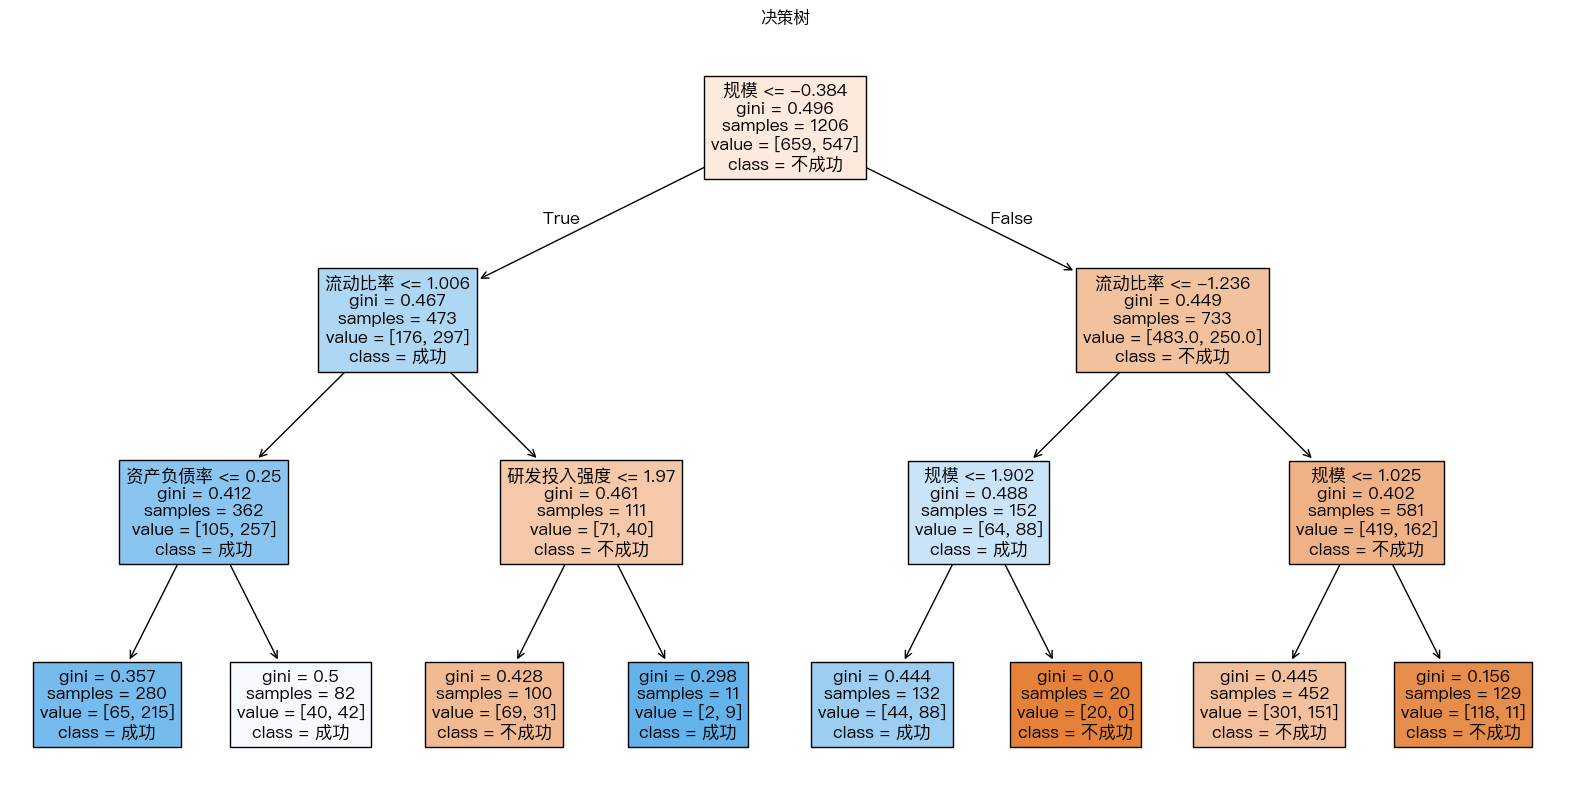

In [14]:
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 使用PingFang HK字体支持中文显示
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, filled=True, feature_names=features, class_names=['不成功', '成功'])
plt.title("决策树")
plt.savefig('决策树.png', dpi=600, bbox_inches='tight')  # 保存图像，分辨率设置为600 DPI
plt.show()


## 2.3 Random Forest


In [15]:
# 随机森林模型训练
forest_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [16]:
# 使用训练集进行交叉验证
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")
print("随机森林交叉验证准确率:", forest_scores)

随机森林交叉验证准确率: [0.69900498 0.74626866 0.67661692]


In [17]:
# 使用训练集进行分类预测
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
y_train_pred_forest

array([0, 0, 1, ..., 0, 0, 1])

In [18]:
# 在训练集上进行预测
train_predictions_forest = forest_clf.predict(X_train)
train_prob_forest = forest_clf.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_forest = accuracy_score(y_train, train_predictions_forest)
print("随机森林训练集准确率:", train_accuracy_forest)

随机森林训练集准确率: 0.9286898839137645



## 2.4 AdaBoost


In [20]:
# 训练AdaBoost模型
ada_clf = AdaBoostClassifier(algorithm='SAMME', random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', random_state=42)

In [21]:
# 使用训练集进行交叉验证
ada_scores = cross_val_score(ada_clf, X_train, y_train, cv=3, scoring="accuracy")
print("AdaBoost交叉验证准确率:", ada_scores)

AdaBoost交叉验证准确率: [0.67412935 0.67164179 0.66666667]


In [22]:
# 使用训练集进行分类预测
y_train_pred_ada = cross_val_predict(ada_clf, X_train, y_train, cv=3)
y_train_pred_ada

array([0, 0, 1, ..., 0, 0, 1])

In [23]:
# 在训练集上进行预测
train_predictions_ada = ada_clf.predict(X_train)
train_prob_ada = ada_clf.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_ada = accuracy_score(y_train, train_predictions_ada)
print("AdaBoost训练集准确率:", train_accuracy_ada)

AdaBoost训练集准确率: 0.7404643449419569



## 2.5 Gradient Boosting


In [25]:
# 使用默认参数训练梯度提升模型
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [26]:
# 使用训练集进行交叉验证
gb_scores = cross_val_score(gb_clf, X_train, y_train, cv=3, scoring="accuracy")
print("梯度提升交叉验证准确率:", gb_scores)

梯度提升交叉验证准确率: [0.6641791  0.70646766 0.65920398]


In [27]:
# 使用训练集进行分类预测
y_train_pred_gb = cross_val_predict(gb_clf, X_train, y_train, cv=3)
y_train_pred_gb

array([0, 0, 1, ..., 0, 0, 1])

In [28]:
# 在训练集上进行预测
train_predictions_gb = gb_clf.predict(X_train)
train_prob_gb = gb_clf.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_gb = accuracy_score(y_train, train_predictions_gb)
print("梯度提升训练集准确率:", train_accuracy_gb)

梯度提升训练集准确率: 0.8864013266998342



## 2.6 XGBoost


In [30]:
# 使用默认参数训练XGBoost模型
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [31]:
# 使用训练集进行交叉验证
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring="accuracy")
print("XGBoost交叉验证准确率:", xgb_scores)

XGBoost交叉验证准确率: [0.67412935 0.7238806  0.66169154]


In [32]:
# 使用训练集进行分类预测
y_train_pred_xgb = cross_val_predict(xgb_clf, X_train, y_train, cv=3)
y_train_pred_xgb

array([0, 0, 1, ..., 0, 0, 1])

In [33]:
# 在训练集上进行预测
train_predictions_xgb = xgb_clf.predict(X_train)
train_prob_xgb = xgb_clf.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_xgb = accuracy_score(y_train, train_predictions_xgb)
print("XGBoost训练集准确率:", train_accuracy_xgb)

XGBoost训练集准确率: 1.0



## 2.7 SVM


In [35]:
# 使用默认参数训练SVM模型
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [36]:
# 使用训练集进行交叉验证
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")
print("SVM交叉验证准确率:", svm_scores)

SVM交叉验证准确率: [0.65671642 0.67910448 0.65671642]


In [37]:
# 使用训练集进行分类预测
y_train_pred_svm = cross_val_predict(svm_clf, X_train, y_train, cv=3)
y_train_pred_svm

array([0, 0, 1, ..., 0, 0, 0])

In [38]:
# 在训练集上进行预测
train_predictions_svm = svm_clf.predict(X_train)
train_prob_svm = svm_clf.predict_proba(X_train)[:, 1]

# 计算训练集上的准确率
train_accuracy_svm = accuracy_score(y_train, train_predictions_svm)
print("SVM训练集准确率:", train_accuracy_svm)

SVM训练集准确率: 0.7728026533996684


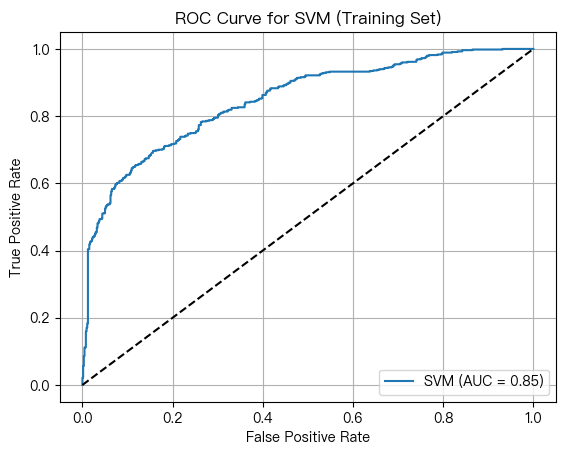

In [39]:
# 绘制训练集上的ROC曲线
fpr_svm, tpr_svm, _ = roc_curve(y_train, train_prob_svm)
auc_svm = roc_auc_score(y_train, train_prob_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM (Training Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 2.8 Integration and Comparison



Logistic Regression 交叉验证准确率: 0.69
Decision Tree 交叉验证准确率: 0.62
Random Forest 交叉验证准确率: 0.71
AdaBoost 交叉验证准确率: 0.67
Gradient Boosting 交叉验证准确率: 0.68
XGBoost 交叉验证准确率: 0.69
SVM 交叉验证准确率: 0.66


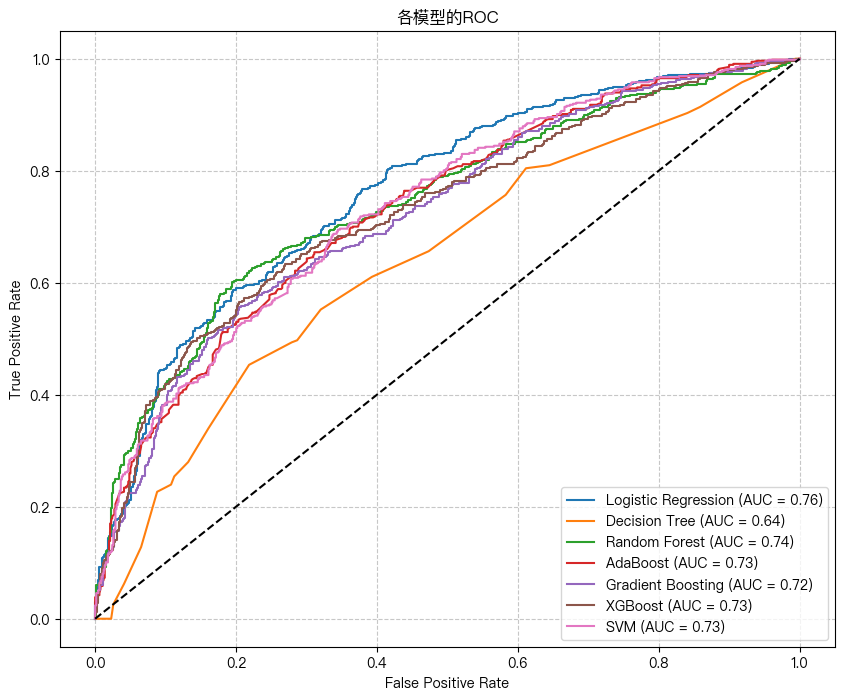

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# 定义所有模型
models = {
    'Logistic Regression': log_reg,
    'Decision Tree': tree_clf,
    'Random Forest': forest_clf,
    'AdaBoost': ada_clf,
    'Gradient Boosting': gb_clf,
    'XGBoost': xgb_clf,
    'SVM': svm_clf
}

plt.figure(figsize=(10, 8))

# 使用训练集进行交叉验证，并绘制交叉验证上的ROC曲线
for name, model in models.items():
    # 使用交叉验证进行预测
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    
    # 计算交叉验证上的准确率
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    print(f"{name} 交叉验证准确率: {cv_scores.mean():.2f}")
    
    # 绘制交叉验证上的ROC曲线
    fpr, tpr, _ = roc_curve(y_train, y_pred_cv)
    auc = roc_auc_score(y_train, y_pred_cv)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('各模型的ROC')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('各模型的ROC.png', dpi=600, bbox_inches='tight') 
plt.show()

综合考虑模型的表现，我们选择以下三个模型进行进一步优化：

1. **XGBoost**

2. **Random Forest**

3. **Gradient Boosting**


# 3. Model Optimization: Grid Search
## 3.1 Define parameter grid


In [56]:
# 定义参数网格
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}


## 3.2 Obtain best parameters


In [57]:
# 初始化模型
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 网格搜索并训练模型
rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
gb_grid_search = GridSearchCV(estimator=gb_clf, param_grid=gb_param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
xgb_grid_search = GridSearchCV(estimator=xgb_clf, param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# 训练模型
rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)
xgb_grid_search.fit(X_train, y_train)

# 获取最佳参数
best_rf_params = rf_grid_search.best_params_
best_gb_params = gb_grid_search.best_params_
best_xgb_params = xgb_grid_search.best_params_

# 打印最佳参数
print("Best Random Forest Params:", best_rf_params)
print("Best Gradient Boosting Params:", best_gb_params)
print("Best XGBoost Params:", best_xgb_params)

Best Random Forest Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}



## 3.3 Evaluate optimized models


In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# 使用最佳参数训练最终模型
best_rf_clf = rf_grid_search.best_estimator_
best_gb_clf = gb_grid_search.best_estimator_
best_xgb_clf = xgb_grid_search.best_estimator_

# 在交叉验证上评估优化后的模型
rf_cv_pred = cross_val_predict(best_rf_clf, X_train, y_train, cv=3, method="predict")
gb_cv_pred = cross_val_predict(best_gb_clf, X_train, y_train, cv=3, method="predict")
xgb_cv_pred = cross_val_predict(best_xgb_clf, X_train, y_train, cv=3, method="predict")

rf_cv_acc = accuracy_score(y_train, rf_cv_pred)
gb_cv_acc = accuracy_score(y_train, gb_cv_pred)
xgb_cv_acc = accuracy_score(y_train, xgb_cv_pred)

print("优化后的 Random Forest 交叉验证准确率:", rf_cv_acc)
print("优化后的 Gradient Boosting 交叉验证准确率:", gb_cv_acc)
print("优化后的 XGBoost 交叉验证准确率:", xgb_cv_acc)


优化后的 Random Forest 交叉验证准确率: 0.7056384742951907
优化后的 Gradient Boosting 交叉验证准确率: 0.697346600331675
优化后的 XGBoost 交叉验证准确率: 0.6923714759535655



## 3.4 Plot optimized ROC curves


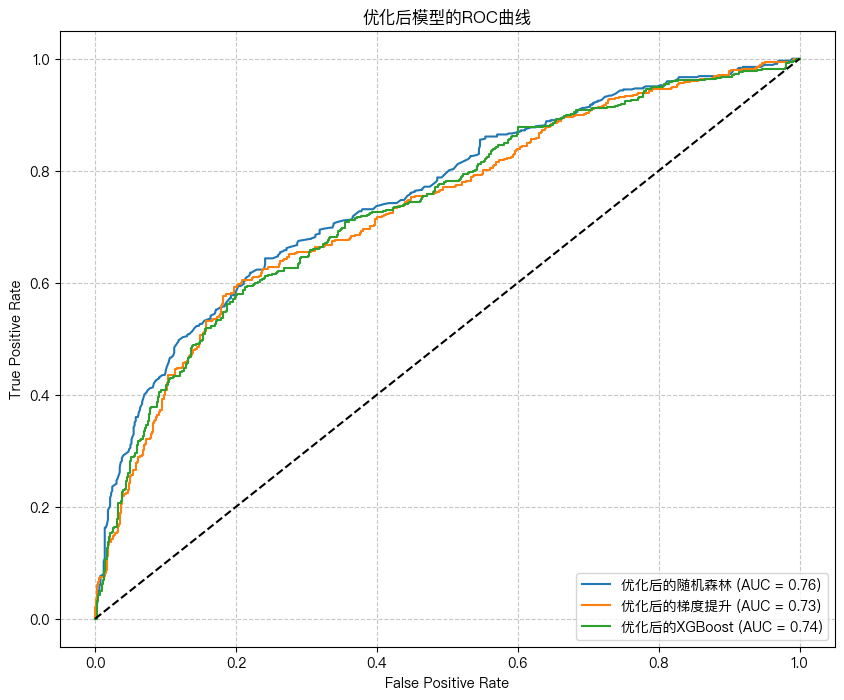

In [59]:
# 绘制交叉验证上的ROC曲线
rf_cv_prob = cross_val_predict(best_rf_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
gb_cv_prob = cross_val_predict(best_gb_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
xgb_cv_prob = cross_val_predict(best_xgb_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_train, rf_cv_prob)
fpr_gb, tpr_gb, _ = roc_curve(y_train, gb_cv_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, xgb_cv_prob)

auc_rf = roc_auc_score(y_train, rf_cv_prob)
auc_gb = roc_auc_score(y_train, gb_cv_prob)
auc_xgb = roc_auc_score(y_train, xgb_cv_prob)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'优化后的随机森林 (AUC = {auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'优化后的梯度提升 (AUC = {auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'优化后的XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('优化后模型的ROC曲线')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('优化后模型的ROC曲线_交叉验证.png', dpi=600, bbox_inches='tight')
plt.show()


# 4. Create Ensemble Model
## 4.1 Define optimized models


In [60]:
# 使用最佳参数训练最终模型
best_rf_clf = rf_grid_search.best_estimator_
best_gb_clf = gb_grid_search.best_estimator_
best_xgb_clf = xgb_grid_search.best_estimator_

In [61]:
# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf_clf),
        ('gb', best_gb_clf),
        ('xgb', best_xgb_clf)
    ],
    voting='soft'  # 使用软投票
)

# 训练投票分类器
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=200,
                                                         random_state=42,
                                                         subsample=0.8)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rou...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [62]:
# 使用交叉验证评估投票分类器
voting_cv_pred = cross_val_predict(voting_clf, X_train, y_train, cv=3, method="predict")
voting_cv_prob = cross_val_predict(voting_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

voting_cv_acc = accuracy_score(y_train, voting_cv_pred)
voting_auc = roc_auc_score(y_train, voting_cv_prob)

print("投票法的交叉验证准确率:", voting_cv_acc)
print("投票法的AUC:", voting_auc)

投票法的交叉验证准确率: 0.7056384742951907
投票法的AUC: 0.7477342269740035


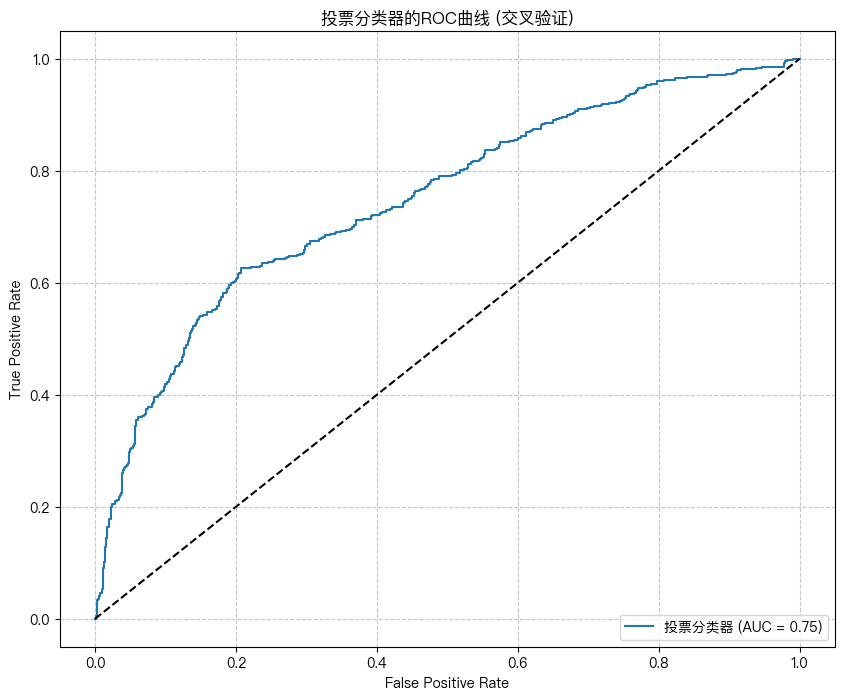

In [63]:
# 绘制交叉验证上的ROC曲线
fpr_voting, tpr_voting, _ = roc_curve(y_train, voting_cv_prob)

plt.figure(figsize=(10, 8))
plt.plot(fpr_voting, tpr_voting, label=f'投票分类器 (AUC = {voting_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('投票分类器的ROC曲线 (交叉验证)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('投票分类器的ROC曲线_交叉验证.png', dpi=600, bbox_inches='tight')
plt.show()


## 4.2 Save four ROC results


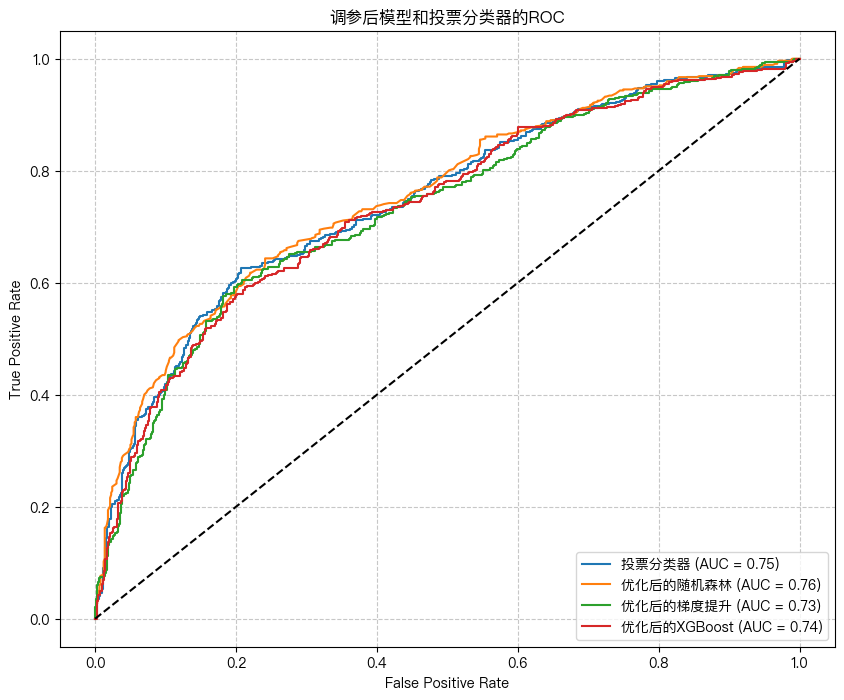

In [64]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 使用交叉验证进行预测并计算概率
voting_cv_prob = cross_val_predict(voting_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
rf_cv_prob = cross_val_predict(best_rf_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
gb_cv_prob = cross_val_predict(best_gb_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
xgb_cv_prob = cross_val_predict(best_xgb_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

# 计算ROC曲线和AUC
fpr_voting, tpr_voting, _ = roc_curve(y_train, voting_cv_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_train, rf_cv_prob)
fpr_gb, tpr_gb, _ = roc_curve(y_train, gb_cv_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, xgb_cv_prob)

auc_voting = roc_auc_score(y_train, voting_cv_prob)
auc_rf = roc_auc_score(y_train, rf_cv_prob)
auc_gb = roc_auc_score(y_train, gb_cv_prob)
auc_xgb = roc_auc_score(y_train, xgb_cv_prob)

# 绘制所有模型的ROC曲线在同一张图上
plt.rcParams['font.sans-serif'] = ['PingFang HK'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 8))
plt.plot(fpr_voting, tpr_voting, label=f'投票分类器 (AUC = {auc_voting:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'优化后的随机森林 (AUC = {auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'优化后的梯度提升 (AUC = {auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'优化后的XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('调参后模型和投票分类器的ROC')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('调参后模型和投票分类器的ROC.png', dpi=600, bbox_inches='tight') 
plt.show()


# 5. Apply Test Set on the Best Model
<span style="color:red;">**Balancing performance, interpretability, and model complexity, we identify Random Forest as the best choice.**</span>

优化后的 Random Forest 测试集准确率: 0.7715231788079471


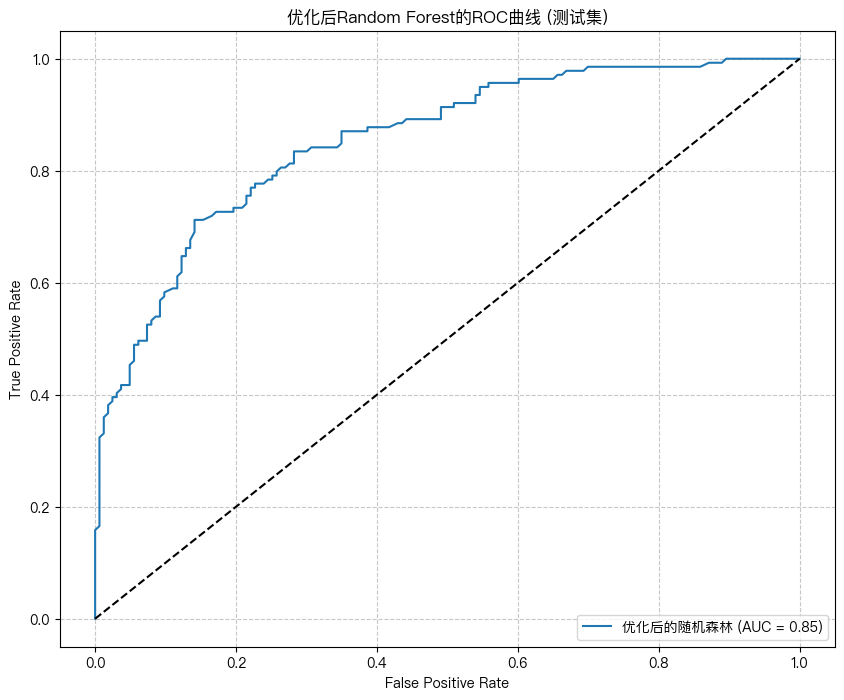

In [65]:
# 在测试集上评估优化后的随机森林模型
rf_test_pred = best_rf_clf.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print("优化后的 Random Forest 测试集准确率:", rf_test_acc)

# 绘制优化后的随机森林模型的ROC曲线
rf_test_prob = best_rf_clf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_prob)

auc_rf = roc_auc_score(y_test, rf_test_prob)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'优化后的随机森林 (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('优化后Random Forest的ROC曲线 (测试集)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('优化后Random Forest的ROC曲线_测试集.png', dpi=600, bbox_inches='tight')  
plt.show()

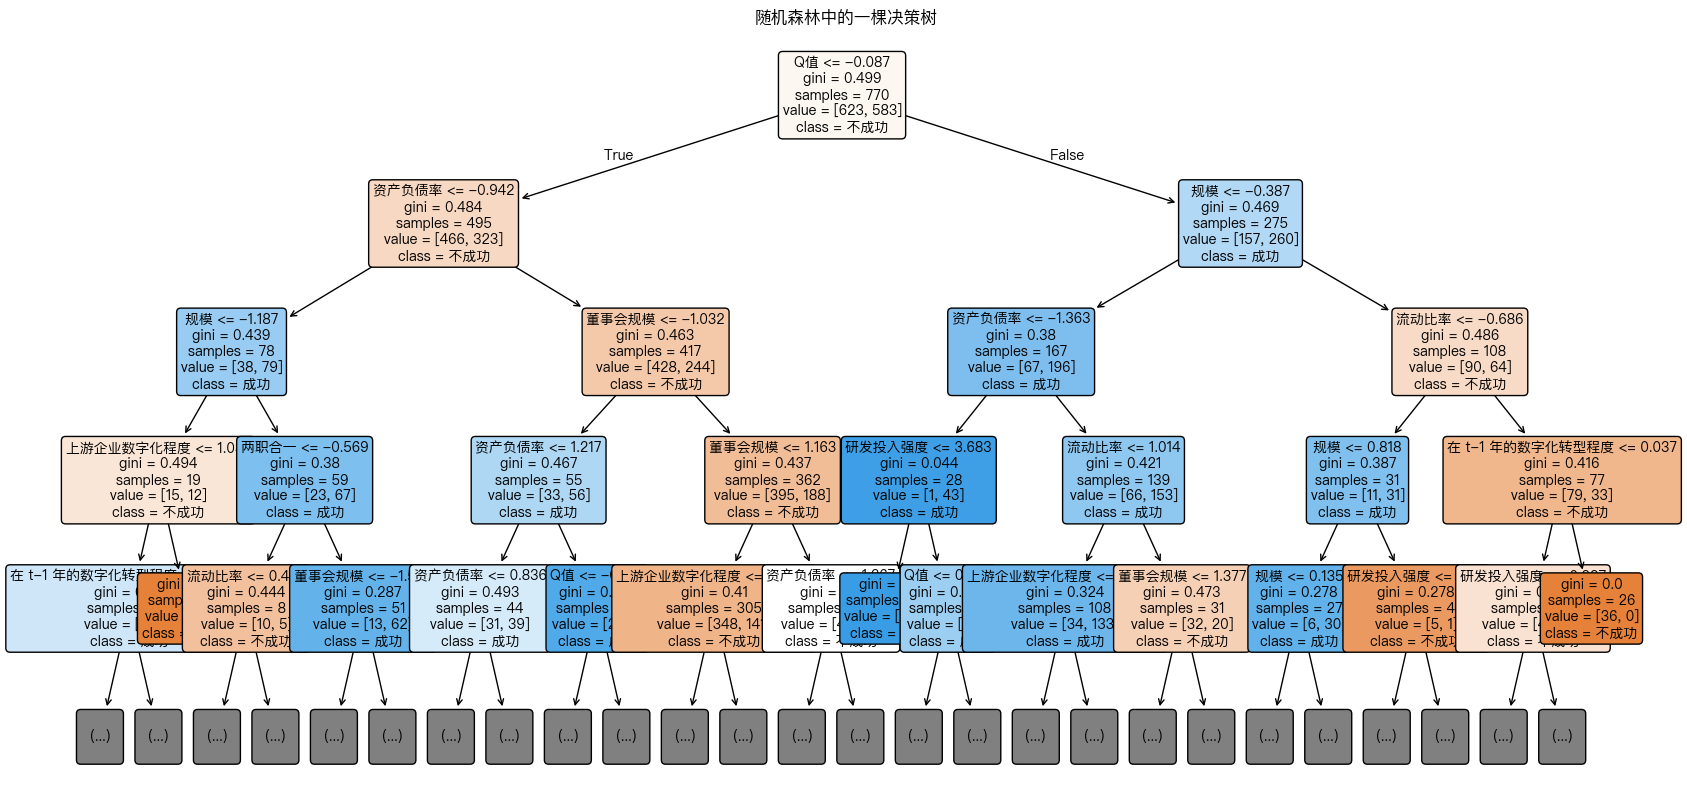

In [70]:
# 绘制随机森林中的一棵决策树，限制树的深度
estimator = best_rf_clf.estimators_[0]  # 提取随机森林中的第一棵树

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 使用PingFang HK字体支持中文显示
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          feature_names=features, 
          class_names=['不成功', '成功'], 
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=4)  # 限制树的深度为4
plt.title("随机森林中的一棵决策树")
plt.savefig('随机森林中的一棵决策树_限制深度.png', dpi=600, bbox_inches='tight')
plt.show()



# 6. Feature Importance Evaluation
## 6.1 Feature importance from Random Forest


           Feature  Importance
6               规模    0.185902
0             流动比率    0.171961
1            资产负债率    0.149878
2               Q值    0.121087
4        上游企业数字化程度    0.108093
7           研发投入强度    0.093246
5  在 t-1 年的数字化转型程度    0.066458
8            董事会规模    0.064954
3             两职合一    0.038420


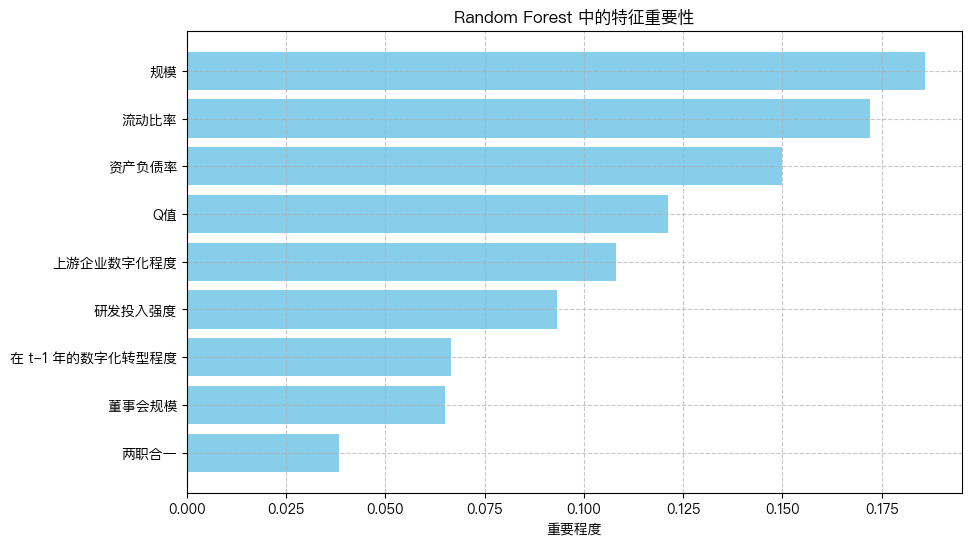

In [66]:
best_rf_clf = rf_grid_search.best_estimator_

# 获取特征重要性
feature_importances = best_rf_clf.feature_importances_

# 将特征名称与特征重要性结合
features = ['流动比率', '资产负债率', 'Q值', '两职合一', '上游企业数字化程度', 
            '在 t-1 年的数字化转型程度', '规模', '研发投入强度', '董事会规模']
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 输出特征重要性
print(feature_importance_df)

# 可视化特征重要性
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 使用PingFang HK字体支持中文显示
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('重要程度')
plt.title('Random Forest 中的特征重要性')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('特征重要性.png', dpi=600, bbox_inches='tight')  


## 6.2 Feature importance from other models (for reference)

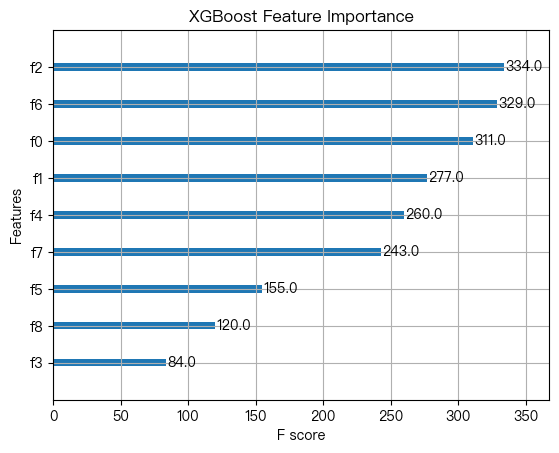

In [52]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# 训练XGBoost模型
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

# 绘制特征重要性
plot_importance(xgb_clf)
plt.title("XGBoost Feature Importance")
plt.show()

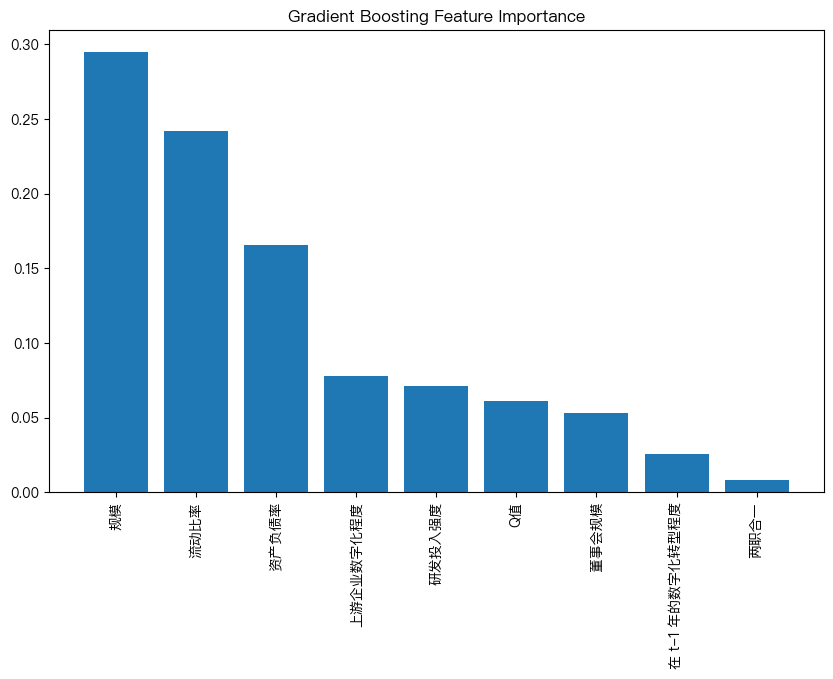

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# 训练Gradient Boosting模型
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

# 获取特征重要性
importances = gb_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# 绘制特征重要性
plt.figure(figsize=(10, 6))
plt.title("Gradient Boosting Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()
